<a href="https://colab.research.google.com/github/sabhasri/VAE-Anomaly-Detection-in-Synthetic-Time-Series-Data/blob/main/VAE_Anomaly_Detection_in_Synthetic_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated 1991 windows (window=50, stride=5)
Injected 40 anomalies (~2.00%)
Train normals: 1560, Val samples: 215, Test samples: 216
Training starting...
Epoch 1/30 - train loss: 193.8623
Epoch 5/30 - train loss: 82.5036
Epoch 10/30 - train loss: 58.3521
Epoch 15/30 - train loss: 52.1624
Epoch 20/30 - train loss: 49.5672
Epoch 25/30 - train loss: 47.2811
Epoch 30/30 - train loss: 46.1589

Results:
                 Method   AUC-PR  Best F1  Recall@95%Prec  Best Threshold
  Reconstruction Error 0.984901 0.952381             0.8       64.570251
ELBO (recon + beta*KL) 0.982474 0.952381             0.8       95.162384


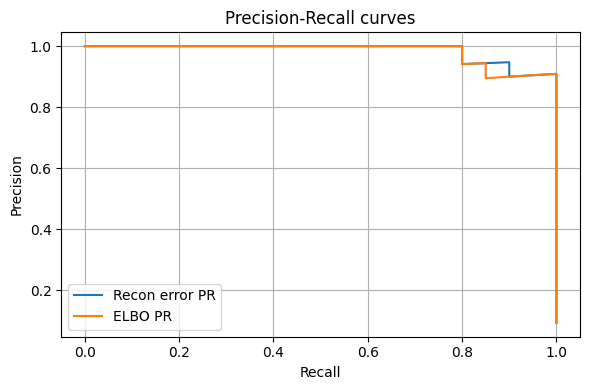

Saved model checkpoint to vae_timeseries_model.pth


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd
import math
import random
import os
import matplotlib.pyplot as plt


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

num_dims = 4
total_timesteps = 10000
window_size = 50
stride = 5
anomaly_ratio = 0.02
latent_dim = 8
hidden_dim = 256
batch_size = 64
lr = 1e-3
num_epochs = 30
beta = 4.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "vae_timeseries_model.pth"


t = np.arange(total_timesteps)
series = np.zeros((total_timesteps, num_dims), dtype=float)

regimes = [
    {"start": 0, "end": 3000, "freq": 0.02, "amp": 1.0, "noise": 0.1},
    {"start": 3000, "end": 6000, "freq": 0.05, "amp": 0.6, "noise": 0.08},
    {"start": 6000, "end": 8000, "freq": 0.01, "amp": 1.5, "noise": 0.12},
    {"start": 8000, "end": 10000, "freq": 0.03, "amp": 0.9, "noise": 0.07},
]

for reg in regimes:
    s, e = reg["start"], reg["end"]
    tt = np.arange(e - s)
    for d in range(num_dims):
        phase = np.random.randn() * 2 * math.pi
        series[s:e, d] = reg["amp"] * np.sin(2 * math.pi * reg["freq"] * tt + phase) + \
                         0.2 * d * np.cos(2 * math.pi * (reg["freq"] * 0.5) * tt + phase/2)
    series[s:e, :] += np.random.normal(scale=reg["noise"], size=(e - s, num_dims))

mean = series.mean(axis=0)
std = series.std(axis=0)
series = (series - mean) / (std + 1e-9)

windows = []
starts = list(range(0, total_timesteps - window_size + 1, stride))
for s in starts:
    windows.append(series[s:s + window_size])
windows = np.stack(windows, axis=0)
num_windows = windows.shape[0]
print(f"Generated {num_windows} windows (window={window_size}, stride={stride})")

num_anomalies = max(1, int(math.ceil(anomaly_ratio * num_windows)))
anom_idx = set(np.random.choice(num_windows, size=num_anomalies, replace=False))
labels = np.zeros(num_windows, dtype=int)

for idx in anom_idx:
    labels[idx] = 1
    kind = np.random.choice(["shift", "spike", "variance"])
    if kind == "shift":
        offset = np.random.uniform(3.0, 6.0) * (np.random.choice([-1, 1]))
        dims = np.random.choice(num_dims, size=max(1, num_dims//2), replace=False)
        windows[idx, :, dims] += offset
    elif kind == "spike":
        for _ in range(np.random.randint(1, 4)):
            tpos = np.random.randint(0, window_size)
            dpos = np.random.randint(0, num_dims)
            windows[idx, tpos, dpos] += np.random.uniform(5.0, 10.0) * (np.random.choice([-1, 1]))
    else:
        windows[idx] += np.random.normal(scale=2.5, size=(window_size, num_dims))

print(f"Injected {num_anomalies} anomalies (~{anomaly_ratio*100:.2f}%)")


class TimeSeriesWindowDataset(Dataset):
    def __init__(self, windows, labels):
        self.windows = windows.astype(np.float32)
        self.labels = labels.astype(np.int64)
    def __len__(self):
        return len(self.windows)
    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

dataset = TimeSeriesWindowDataset(windows, labels)

normal_idx = np.where(labels == 0)[0]
anomaly_idx = np.where(labels == 1)[0]
np.random.shuffle(normal_idx)

n_train_norm = int(0.8 * len(normal_idx))
n_val_norm = int(0.1 * len(normal_idx))
train_idx = normal_idx[:n_train_norm]
val_idx = np.concatenate([normal_idx[n_train_norm:n_train_norm + n_val_norm], anomaly_idx[:len(anomaly_idx)//2]])
test_idx = np.concatenate([normal_idx[n_train_norm + n_val_norm:], anomaly_idx[len(anomaly_idx)//2:]])

train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx),
                          batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

print(f"Train normals: {len(train_idx)}, Val samples: {len(val_idx)}, Test samples: {len(test_idx)}")


input_dim = window_size * num_dims

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        B = x.size(0)
        x_flat = x.view(B, -1)
        h = self.enc(x_flat)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        recon_flat = self.dec(z)
        recon = recon_flat.view(B, window_size, num_dims)
        return recon, mu, logvar

model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)


def elbo_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = ((recon_x - x) ** 2).view(x.size(0), -1).sum(dim=1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    loss = recon_loss + beta * kl
    return loss.mean(), recon_loss.detach().cpu().numpy(), kl.detach().cpu().numpy()

optimizer = optim.Adam(model.parameters(), lr=lr)



print("Training starting...")
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for bx, _ in train_loader:
        bx = bx.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(bx)
        loss, _, _ = elbo_loss(recon, bx, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * bx.size(0)
    avg_train_loss = running_loss / len(train_loader.dataset)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs} - train loss: {avg_train_loss:.4f}")


model.eval()
all_recon_scores = []
all_elbo_scores = []
all_labels = []

with torch.no_grad():
    for bx, by in test_loader:
        bx = bx.to(device)
        recon, mu, logvar = model(bx)
        recon_err = ((recon - bx) ** 2).view(bx.size(0), -1).sum(dim=1).cpu().numpy()
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).cpu().numpy()
        elbo = recon_err + beta * kl
        all_recon_scores.extend(recon_err.tolist())
        all_elbo_scores.extend(elbo.tolist())
        all_labels.extend(by.numpy().tolist())

all_recon_scores = np.array(all_recon_scores)
all_elbo_scores = np.array(all_elbo_scores)
all_labels = np.array(all_labels)

def compute_pr_and_best(scores, labels):
    prec, rec, thr = precision_recall_curve(labels, scores)
    pr_auc = auc(rec, prec)

    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = np.nanargmax(f1)

    if best_idx == 0:
        best_thresh = thr[0] if len(thr)>0 else None
    else:
        best_thresh = thr[best_idx - 1]
    return pr_auc, best_thresh, f1[best_idx], prec, rec, thr

pr_recon, thresh_recon, bestf1_recon, prec_recon, rec_recon, thr_recon = compute_pr_and_best(all_recon_scores, all_labels)
pr_elbo, thresh_elbo, bestf1_elbo, prec_elbo, rec_elbo, thr_elbo = compute_pr_and_best(all_elbo_scores, all_labels)

def recall_at_precision(precision, recall, thresholds, target_p=0.95):
    inds = np.where(precision >= target_p)[0]
    if len(inds) == 0:
        return 0.0, None
    best_ind = inds[np.argmax(recall[inds])]
    if best_ind == 0:
        thr = thresholds[0] if len(thresholds)>0 else None
    else:
        thr = thresholds[best_ind - 1]
    return recall[best_ind], thr

rec95_recon, thr95_recon = recall_at_precision(prec_recon, rec_recon, thr_recon, target_p=0.95)
rec95_elbo, thr95_elbo = recall_at_precision(prec_elbo, rec_elbo, thr_elbo, target_p=0.95)

results = pd.DataFrame({
    "Method": ["Reconstruction Error", "ELBO (recon + beta*KL)"],
    "AUC-PR": [pr_recon, pr_elbo],
    "Best F1": [bestf1_recon, bestf1_elbo],
    "Recall@95%Prec": [rec95_recon, rec95_elbo],
    "Best Threshold": [thresh_recon, thresh_elbo]
})
print("\nResults:\n", results.to_string(index=False))


plt.figure(figsize=(6,4))
plt.plot(rec_recon, prec_recon, label="Recon error PR")
plt.plot(rec_elbo, prec_elbo, label="ELBO PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

torch.save({
    "model_state_dict": model.state_dict(),
    "mean": mean,
    "std": std,
    "window_size": window_size,
    "num_dims": num_dims,
    "beta": beta
}, checkpoint_path)
print(f"Saved model checkpoint to {checkpoint_path}")
